Script generar modelos de prediccion usando XG-Boost, para predecir el numerador y el denominador 
de los indicadores del indice de Necesidades Jurídicas satisfechas para todos los municipios 

In [54]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import sklearn
import multiprocessing
import numpy  as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import xgboost as xgb
from xgboost import plot_importance
import os
import openpyxl

In [55]:
carpeta_actual = os.getcwd()
carpeta_datos = 'datos_intermedios'
ruta_Base_mix = os.path.join(carpeta_actual, carpeta_datos, '1_Base_para_modelos_ECSC2019.xlsx')
ruta_Registros_complet = os.path.join(carpeta_actual, carpeta_datos, '2_Base_completa_registros_ECSC2019.xlsx')
Base_mix1 = pd.read_excel(ruta_Base_mix)
Registros_complet= pd.read_excel(ruta_Registros_complet)

In [56]:
#variables explicativas del modelo
var=list(Registros_complet.drop(columns=['mpio_ccnct', 'mpio_cnmbr', 'dpto_cnmbr']).columns)

In [57]:
#creamos la matriz para almacenar las salidas del modelo
errores=pd.DataFrame()
resultados=pd.DataFrame()
df_pred_mun=pd.DataFrame()
df_pred_test=pd.DataFrame()
df_pred_train=pd.DataFrame()
predicciones_mun=pd.DataFrame()

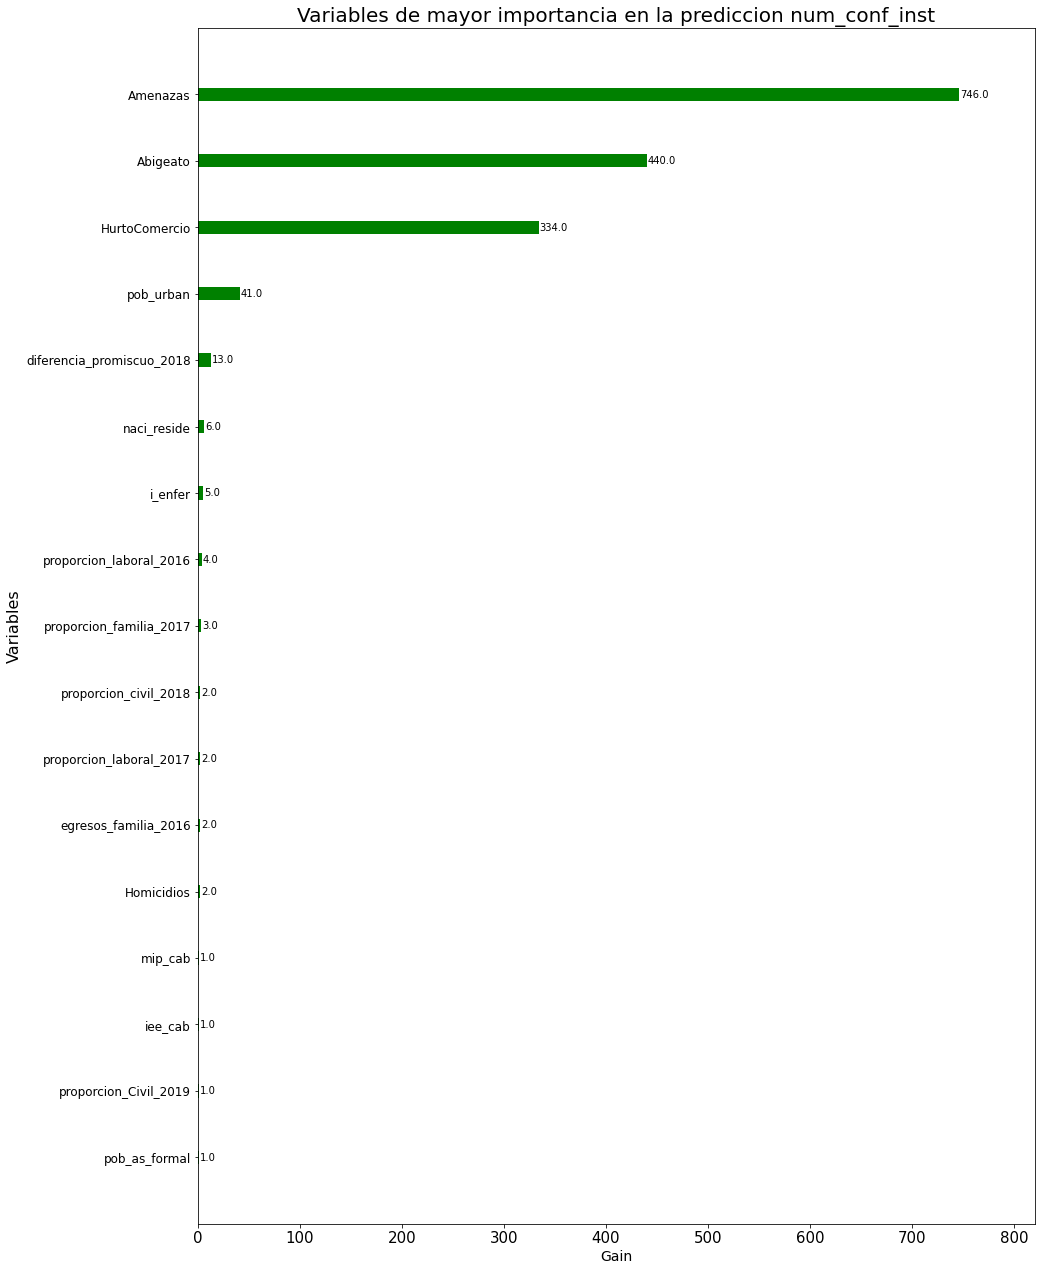

In [72]:
#Se generan los modelos con validación cruzada y selección de los mejores hiperparámetros para los componentes de los indicadores (numeradores y denominadores)
#Ind=['num_des_rutas', 'den_des_rutas', 'num_acc_ase', 'den_acc_ase',
#       'num_nec_jur', 'den_nec_jur', 'num_efec_pac', 'den_efec_pac',
#       'num_conf_inst', 'den_conf_inst', 'num_cumpl', 'den_cumpl',
#       'num_per_sv_jus', 'den_per_sv_jus', 'num_rta_asist_inst',
#       'den_rta_asist_inst']

Ind=['num_conf_inst', 'den_conf_inst']

for i in Ind:
    X, y = Base_mix1[var], Base_mix1[i]
    data_dmatrix = xgb.DMatrix(data=X,label=y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
#Grupo de hiperparámetros a evaluar
    param_grid = {'max_depth'        : [5, 20, 100],
                  'learning_rate'    : [0.1, 0.001, 0.0001],# 0.005, 0.00001,  0.00005]
                   'n_estimators'    : [60, 600, 6000],# 20000, 60000, 80000, 100000]
                   'alpha': [0.5, 0.7, 1]
                 }

#Parámetros fijos
    fit_params = {"eval_set"              : [(X_test, y_test)],
                  "verbose"               : 0,
                               }
# Búsqueda por grid search con validación cruzada
    grid = GridSearchCV(
    estimator  = XGBRegressor(random_state = 123),
    param_grid = param_grid,
    scoring    = 'neg_root_mean_squared_error',
    n_jobs     = multiprocessing.cpu_count() - 1,
    cv         = 5, 
    refit      = True,
    verbose    = 0,
    return_train_score = True
    )

    grid.fit(X = X_train, y = y_train, **fit_params)

    # Resultados de los errores de test y train con validación cruzada
    resultados1 = pd.DataFrame(grid.cv_results_).filter(regex = '(param.*|mean_t|std_t)').drop(columns = 'params').sort_values('mean_test_score', ascending = False).head(1)
    resultados1['Indicador']=i
    resultados=pd.concat([resultados, resultados1], axis=0)
    #se realizan las predicciones del set de train, test y grupo completo
    X_all, y_all = Registros_complet[var], Registros_complet['mpio_ccnct']
    modelo_final = grid.best_estimator_
    pred_train = modelo_final.predict(X=X_train)
    pred_test = modelo_final.predict(X=X_test)
    pred_compl = modelo_final.predict(X=X_all)
    #se calcula el error cuadratico medio del set de train, test y grupo completo
    rmse_train=np.sqrt(mean_squared_error(y_train, pred_train))
    rmse_test=np.sqrt(mean_squared_error(y_test, pred_test))
    #se crean los DataFrame con las predicciones
    df_pred_test1=pd.DataFrame({i: y_test, 'pred_'+i : pred_test})
    df_pred_test=pd.concat([df_pred_test, df_pred_test1], axis=1)
    df_pred_train1=pd.DataFrame({i: y_train, 'pred_'+i : pred_train})
    df_pred_train=pd.concat([df_pred_train, df_pred_train1], axis=1)
    df_pred_mun1 = pd.DataFrame({'pred_'+i : pred_compl})
    df_pred_mun=pd.concat([df_pred_mun, df_pred_mun1], axis=1)
    #se crean los DataFrame con los errores
    error_test={'nombre_ind': i, 'error_train': rmse_train, 'error_test': rmse_test}
    errores=errores._append(error_test, ignore_index=True)
    #Gráfica de la importancia de los predictores
    xgb.plot_importance(modelo_final,  color='green', grid=False, height=0.2)  #importance_type = 'gain'
    plt.rcParams['figure.figsize'] = [15, 22]
    #plt.style.use('seaborn-white')
    plt.ylabel('Variables', fontsize=16)
    plt.xlabel('Gain', fontsize=14)
    plt.title('Variables de mayor importancia en la prediccion '+ i, fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=12)
    plt.show()

In [ ]:
# En esta tabla se encuentra la media del error cuadrático medio de los diferentes subconjuntos usados con para entrenar el modelo de validadación cruzada, los subconjuntos provienen de los datos de entrenamiento 
resultados
#esta tabla contiene el error cuadráatico medio de los datos totales de test y prueba, con el modelo final
errores
#Esta tabla contiene las predicciones para la totalidad de departamentos
df_pred_mun.head(2)
#Esta tabla contiene las predicciones para los datos de entrenamiento
df_pred_train
#Esta tabla contiene las predicciones para los datos de test
df_pred_test

In [ ]:
#Adicionar los nombres de los municipios  y departamento
nom_dep=Registros_complet[['mpio_ccnct', 'dpto_cnmbr', 'mpio_cnmbr']]
df_pred_mun=pd.concat([nom_dep, df_pred_mun], axis=1)
df_pred_mun.head(2)

In [ ]:
#Calculo de indicadores a nivel municipal
#df_pred_mun['des_rutas_pred']=df_pred_mun['pred_num_des_rutas']/df_pred_mun['pred_den_des_rutas']
df_pred_mun['acc_ase_pred']=df_pred_mun['pred_num_acc_ase']/df_pred_mun['pred_den_acc_ase']
#df_pred_mun['nec_jur_pred']=df_pred_mun['pred_num_nec_jur']/df_pred_mun['pred_den_nec_jur']
#df_pred_mun['efec_pac_pred']=df_pred_mun['pred_num_efec_pac']/df_pred_mun['pred_den_efec_pac']
#df_pred_mun['conf_insts_pred']=df_pred_mun['pred_num_conf_inst']/df_pred_mun['pred_den_conf_inst']
df_pred_mun['cumpl_pred']=df_pred_mun['pred_num_cumpl']/df_pred_mun['pred_den_cumpl']
#df_pred_mun['per_sv_jus_pred']=df_pred_mun['pred_num_per_sv_jus']/df_pred_mun['pred_den_per_sv_jus']
#df_pred_mun['rta_asist_inst_pred']=df_pred_mun['pred_num_rta_asist_inst']/df_pred_mun['pred_den_rta_asist_inst']

df_pred_mun.head(2)

Indicadores_mun=df_pred_mun.filter(regex = "dpto*|mpio.*|.*_pred")
Indicadores_mun.head(2)
#Indicadores_mun.to_excel('Indicadores_pron_mun.xlsx')